# Notebook for CCA testing

In [1]:
## What do we need?

In [31]:
%pylab inline
import importlib

Populating the interactive namespace from numpy and matplotlib


## Create test datasets

Correlation matrix:


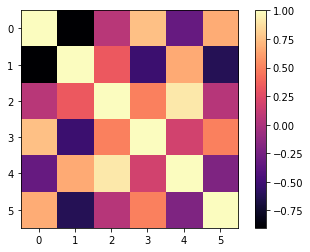

In [65]:
sample_size = 28*28

# X is 3 band normal multivariate with slight correlation between samples
X = np.random.multivariate_normal([0,2,3],[[1,-0.9,0.1],
                                           [-0.9,1,0.3],
                                           [0.1,0.3,1]],size=sample_size)

# Now set Y setting explisitly coefficents for CCA to recover and add some multivariate noise
Y = np.concatenate( 
    (
    ( X[:,0]*0.3+X[:,1]*-0.2+X[:,2]*0.4 )[:,np.newaxis],
    ( X[:,0]*-0.02+X[:,1]*1.2+X[:,2]*2.4 )[:,np.newaxis],
    ( X[:,0]*0.2+X[:,1]*-0.1+X[:,2]*0.03 )[:,np.newaxis],
    ),
    axis=1
) + np.random.normal(0,0.3,size=(sample_size,3))+1

print('Correlation matrix:')
imshow( np.corrcoef(X,Y,rowvar=False), cmap='magma' );
colorbar();

## Determine what would we expect? (using funcs from sklearn)

Correlation coef: 0.995065588834
x_weights =  0.016, 0.475, 0.880
y_weights =  0.009, 1.000,-0.012


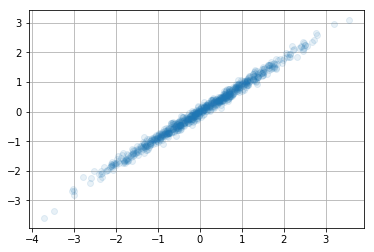

In [77]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=1)

cca.fit(X,Y)

new_X, new_Y = cca.transform(X,Y)
print('Correlation coef:',np.corrcoef( np.ravel(new_X),np.ravel(new_Y) )[0,1] )
print('x_weights = {: >6.3f},{: >6.3f},{: >6.3f}'.format(*cca.x_weights_[:,0] ) )
print('y_weights = {: >6.3f},{: >6.3f},{: >6.3f}'.format(*cca.y_weights_[:,0] ) )
plot(new_X,new_Y,'o',alpha=0.1);
grid(True);
#new_X = new_X/( new_X/new_Y ).mean() # rescale data

## Check data module

In [71]:
import importlib
import CCA.data as CCADATA
importlib.reload(CCADATA);
from CCA.data import SampleFeed

In [74]:
dat = SampleFeed(2) # Batch generator with batch size = 1

In [75]:
for i in dat.batches():
    print(i)
    break
    
# Seems to work fine

{'X': array([[-0.44597687,  2.40545799,  3.13951285],
       [-0.78737397,  2.02150836,  1.6364575 ]]), 'Y': array([[  1.78397538,  11.29150553,   0.39926051],
       [  1.16383708,   7.0131084 ,   0.47490588]])}


## Create tensorflow function for covariance matrix

In [76]:
import tensorflow as tf

In [85]:
# Simple case for 2 1-dimensional vectors

x = tf.constant([1, 4, 2, 5, 6, 24, 15], dtype=tf.float64)
y = tf.constant([8, 5, 4, 6, 2, 1, 1], dtype=tf.float64)

cov_xx = 1 / (tf.shape(x)[0] - 1) * tf.reduce_sum((x - tf.reduce_mean(x))**2)
cov_yy = 1 / (tf.shape(x)[0] - 1) * tf.reduce_sum((y - tf.reduce_mean(y))**2)
cov_xy = 1 / (tf.shape(x)[0] - 1) * tf.reduce_sum((x - tf.reduce_mean(x)) * (y - tf.reduce_mean(y)))

with tf.Session() as sess:
    sess.run([cov_xx, cov_yy, cov_xy])
    #print(cov_xx.eval(), cov_yy.eval(), cov_xy.eval())
    cov = tf.constant([[cov_xx.eval(), cov_xy.eval()], [cov_xy.eval(),
        cov_yy.eval()]])
    mat = np.array(cov.eval())
    
print('TF Covariance matrix:\n',mat)

x = np.array([1,4,2,5,6, 24, 15], dtype=float)
y = np.array([8,5,4,6,2,1,1], dtype=float)

pc = np.cov(x,y)
print('NP Covariance matrix:\n',pc)

TF Covariance matrix:
 [[ 69.80952454 -17.1428566 ]
 [-17.1428566    7.14285707]]
NP Covariance matrix:
 [[ 69.80952381 -17.14285714]
 [-17.14285714   7.14285714]]


In [117]:
# Case for 2 2-dimensional vectors

batch_size = 10

x = tf.constant(X[:batch_size], dtype=tf.float64)
y = tf.constant(Y[:batch_size], dtype=tf.float64)
x_mean = tf.reduce_mean(x, 0)
y_mean = tf.reduce_mean(y, 0)

xx_cov = tf.matmul( tf.transpose(x-x_mean), (x-x_mean) )

with tf.Session() as sess:
    print( xx_cov.eval() )


[[ 6.15658934 -3.76897107  4.23957905]
 [-3.76897107  3.9919183   0.104586  ]
 [ 4.23957905  0.104586    7.98035678]]


In [144]:
x[:,0]

array([-1.12719502, -1.24153496,  1.32343155,  0.29872492, -0.49210437,
        0.43460372,  0.11605665, -0.67855782,  0.78259938,  0.09969157])

In [152]:
# real covariance matrix
[
    [ np.mean( (x[:,0]-x[:,0].mean())**2 ), np.mean( (x[:,0]-x[:,1].mean())**2 ), np.mean( (x[:,0]-x[:,2].mean())**2 ) ],
    [ np.mean( (x[:,1]-x[:,0].mean())**2 ), np.mean( (x[:,1]-x[:,1].mean())**2 ), np.mean( (x[:,1]-x[:,2].mean())**2 ) ],
    [ np.mean( (x[:,2]-x[:,0].mean())**2 ), np.mean( (x[:,2]-x[:,1].mean())**2 ), np.mean( (x[:,2]-x[:,2].mean())**2 ) ]
]

[[0.61565893419764994, 5.0091808624233192, 10.331139234264697],
 [4.7927137577679328, 0.39919182954226384, 1.4414154584113148],
 [10.513515978295121, 1.8402593070971229, 0.79803567822807153]]

In [160]:
x.T

array([[-1.12719502, -1.24153496,  1.32343155,  0.29872492, -0.49210437,
         0.43460372,  0.11605665, -0.67855782,  0.78259938,  0.09969157],
       [ 2.50641048,  2.86902897,  1.64381071,  1.91145865,  2.49892337,
         1.32975656,  1.04809358,  2.83165496,  1.38993669,  2.44737141],
       [ 2.03925965,  2.11607537,  4.31451475,  3.80493567,  2.72657083,
         2.58312892,  1.83824173,  3.39834283,  3.45655909,  4.40775202]])

In [154]:
x-x.mean(axis=0)

array([[-1.07876659,  0.45876594, -1.02927843],
       [-1.19310652,  0.82138443, -0.95246272],
       [ 1.37185999, -0.40383382,  1.24597666],
       [ 0.34715336, -0.13618589,  0.73639759],
       [-0.44367593,  0.45127883, -0.34196726],
       [ 0.48303215, -0.71788798, -0.48540917],
       [ 0.16448509, -0.99955096, -1.23029635],
       [-0.63012938,  0.78401042,  0.32980474],
       [ 0.83102782, -0.65770785,  0.388021  ],
       [ 0.14812001,  0.39972687,  1.33921394]])

In [147]:
x = X[:batch_size]
y = Y[:batch_size]

np.matmul( (x-x.mean(axis=0)).T, (x-x.mean(axis=0)) )

array([[ 6.15658934, -3.76897107,  4.23957905],
       [-3.76897107,  3.9919183 ,  0.104586  ],
       [ 4.23957905,  0.104586  ,  7.98035678]])

In [505]:
## A
a = np.tensordot(np.array([1,1,1]),np.array([[1,3,3],[2,2,4],[1,2,4],[2,3,3]]).T,axes=0)
b = np.array([0.5,0.4,0.3])[np.newaxis,:,np.newaxis]
(a-b).mean(axis=2)

array([[ 1. ,  2.1,  3.2],
       [ 1. ,  2.1,  3.2],
       [ 1. ,  2.1,  3.2]])

In [520]:
## B
a = np.tensordot(np.array([1,1,1]),np.array([[1,3,3],[2,2,4],[1,2,4],[2,3,3]]).T,axes=0).swapaxes(0,1)
b = np.array([0.5,0.4,0.3])[:,np.newaxis,np.newaxis]
(a-b).mean(axis=2)

array([[ 1. ,  1. ,  1. ],
       [ 2.1,  2.1,  2.1],
       [ 3.2,  3.2,  3.2]])

In [307]:
b.shape

(3, 1, 1)

In [523]:
tx = np.tensordot(np.array([1,1,1]),x.T,axes=0)
ty = np.tensordot(np.array([1,1,1]),x.T,axes=0).swapaxes(0,1)
tm = x.mean(axis=0)[:,np.newaxis,np.newaxis]
c = np.multiply( (tx-tm), (ty-tm) ).T.mean(axis=0)
c

array([[ 0.61565893, -0.37689711,  0.4239579 ],
       [-0.37689711,  0.39919183,  0.0104586 ],
       [ 0.4239579 ,  0.0104586 ,  0.79803568]])

In [422]:
# Calculate true covariance matrix

x1 = x[:,0]
x2 = x[:,1]
x3 = x[:,2]

np.array( [
    [ np.mean( (x1-x1.mean())*(x1-x1.mean()) ), np.mean( (x1-x1.mean())*(x2-x2.mean()) ), np.mean( (x1-x1.mean())*(x3-x3.mean())) ],
    [ np.mean( (x2-x2.mean())*(x1-x1.mean()) ), np.mean( (x2-x2.mean())*(x2-x2.mean()) ), np.mean( (x2-x2.mean())*(x3-x3.mean())) ],
    [ np.mean( (x3-x3.mean())*(x1-x1.mean()) ), np.mean( (x3-x3.mean())*(x2-x2.mean()) ), np.mean( (x3-x3.mean())*(x3-x3.mean())) ],
])

array([[ 0.61565893, -0.37689711,  0.4239579 ],
       [-0.37689711,  0.39919183,  0.0104586 ],
       [ 0.4239579 ,  0.0104586 ,  0.79803568]])

In [524]:
## Now implement the same thing with tensorflow

In [579]:
np.random.normal(0,1)

1.8589302036763817

In [586]:
batch_size = 10
band_num = 3
learning_rate = 0.01

x = tf.constant(X[:batch_size], dtype=tf.float64)
y = tf.constant(Y[:batch_size], dtype=tf.float64)
x_mean = tf.reduce_mean(x, 0)
y_mean = tf.reduce_mean(y, 0)

a = tf.Variable( [ [ np.random.normal(0,1) ] for i in range(band_num)], dtype=tf.float64, name = 'x_weights_' )
b = tf.Variable( [ [ np.random.normal(0,1) ] for i in range(band_num)], dtype=tf.float64, name = 'y_weights_' )

xx_cov = tf.matmul( tf.transpose(x-x_mean), (x-x_mean) )/batch_size
yy_cov = tf.matmul( tf.transpose(y-y_mean), (y-y_mean) )/batch_size
xy_cov = tf.matmul( tf.transpose(x-x_mean), (y-y_mean) )/batch_size

norm1 = tf.sqrt( tf.matmul( tf.matmul(tf.transpose(a),xx_cov), a ) )
norm2 = tf.sqrt( tf.matmul( tf.matmul(tf.transpose(b),yy_cov), b ) )

p = -(tf.matmul( tf.matmul(tf.transpose(a),xy_cov), b )/norm1/norm2)[0,0]

optimizer = tf.train.AdamOptimizer(learning_rate).minimize( p )

var_init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(var_init)
    
    sess.run( optimizer )
#     print( xx_cov.eval() )
#     print( yy_cov.eval() )
#     print( xy_cov.eval() )

    print( 'a = ',*a.eval().T )
    print( 'b = ',*b.eval().T )
    print( 'p = ',p.eval() )

a =  [-0.57998927  1.6235312  -1.29228503]
b =  [ 0.31222761 -0.20830436 -0.55675436]
p =  -0.301157043274


In [573]:
## Calc real correlation coefficient

In [574]:
x = X[:batch_size]
y = Y[:batch_size]

np.corrcoef( x.mean(axis=1), y.mean(axis=1) )[0,1]

0.97365757640132

In [587]:
x.shape

TensorShape([Dimension(10), Dimension(3)])

## Testing model

In [633]:
import importlib
import CCA.model as CCAMODEL
importlib.reload(CCAMODEL);
from CCA.model import CannonicalCorrelation

import CCA.data as CCADATA
importlib.reload(CCADATA);
from CCA.data import SampleFeed

import CCA.session as CCASESS
importlib.reload(CCASESS);
from CCA.session import AdamOptimizer

mdl = CannonicalCorrelation(10,3)
dat = SampleFeed(10)
sess = AdamOptimizer(mdl,dat)

In [634]:
sess.optimize()

Initialization weights:
x_weights_: -0.090814 0.384702 -0.463678
y_weights_: 2.2584 -0.507452 -0.611193

############# Epoch:   50 #############
x_weights_: 0.251736 -0.147213 -0.554739
y_weights_: 1.1941 -1.25387 -0.0818673
Loss:  -0.988641
############# Epoch:  100 #############
x_weights_: 0.0626438 -0.278952 -0.583577
y_weights_: 0.262001 -1.49708 0.139912
Loss:  -0.994547
############# Epoch:  150 #############
x_weights_: 0.0224539 -0.290684 -0.605294
y_weights_: -0.106495 -1.51631 0.0905075
Loss:  -0.994941
############# Epoch:  200 #############
x_weights_: 0.019989 -0.298373 -0.625536
y_weights_: -0.1446 -1.52236 0.0816609
Loss:  -0.994958
############# Epoch:  250 #############
x_weights_: 0.0202263 -0.306894 -0.644116
y_weights_: -0.150167 -1.55801 0.0823626
Loss:  -0.994965
############# Epoch:  300 #############
x_weights_: 0.0205975 -0.315237 -0.662044
y_weights_: -0.153886 -1.59537 0.0839531
Loss:  -0.99497
############# Epoch:  350 #############
x_weights_: 0.0209654 -0

In [651]:
# test found weights
x_weights = [0.0250464, -0.411897, -0.870212]
y_weights = [-0.196449, -2.04132, 0.103941]

In [652]:
new_X = (X*x_weights).sum(axis=1)
new_Y = (Y*y_weights).sum(axis=1)

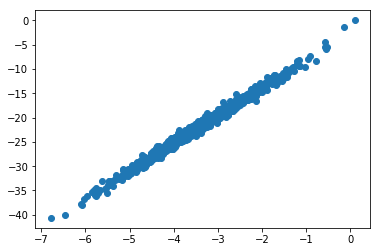

In [653]:
plot(new_X,new_Y,'o')